In [109]:
%matplotlib widget
import matplotlib.pyplot as plt
import numpy as np 

%reload_ext autoreload
%aimport Funcs
%aimport fluid_flow
%aimport parameters
%aimport visualization
from Funcs import advance_adv_diff_RK3, advance_adv_diff_RK4
from fluid_flow import advance_fluid_flow, set_boundary, dt_fluid_flow
from Funcs import metric_L0, metric_RMS
from parameters import * # <-- dangerous; make sure to put only global constants in that file

In [195]:
from math import sin, pi, exp
from poisson_solver import get_atol
import time

N=50
dx, dy, Ns_c, Nc_lw = parameters.set_resolution(N,N)
dt = dt_fluid_flow(dx, Fo=0.3)

# total simulation time
t = 0.025

# number of convergence measurements
N_loop = 100

# time in [s] between two measurements
dt_measure = t / N_loop

# number of iterations between 2 convergence measurements
Nt = int(np.round(dt_measure / dt))

Nt0=1

    
def perfo_analysis(amax=1e-4, amin=1e-8, tmax=0.01):
    
    # initial setup of velocity field
    u0 = np.zeros((N,N))
    v0 = np.copy(u0)
    u0,v0 = set_boundary(u0,v0,Ns_c, Nc_lw)
    u, v = np.copy(u0), np.copy(v0)

    # w parameter for the Poisson solver:
    w = 2 / (1 + sin(pi/N))

    # placeholders for the respective metrics
    L0 = np.zeros((2,N_loop))
    L2 = np.zeros_like(L0)

    n_conv_check = 1

    # initial warm-up:
    u, v, P,_, NSOR = advance_fluid_flow(Nt0, u, v, advance_adv_diff_RK3, dt, diag=True)

    t0 = time.time()

    NNSOR = np.zeros((N_loop, Nt))

    # convergence analysis:
    for i in range(N_loop):

        _t = i * dt * Nt + dt * Nt0 # current phyiscal time in [s]
        atol = get_atol(_t, amin, amax, tmax)

        u_old, v_old = np.copy(u), np.copy(v)
        u, v, P,_,NSOR = advance_fluid_flow(Nt, u, v, advance_adv_diff_RK3, dt, w=w, atol=atol, P=P, n_conv_check=n_conv_check, diag=True)

        NNSOR[i] = NSOR
        # measurements:
        L0[0,i] = metric_L0(u_old, u)
        L0[1,i] = metric_L0(v_old, v) 

        L2[0,i] = metric_RMS(u_old, u)
        L2[1,i] = metric_RMS(v_old, v)
    print('CPU time [s]: ', time.time() - t0)
    
    T = np.arange(N_loop) * dt * Nt + dt * Nt0
    
    results = [L0, L2, NNSOR, T]
    return results

In [255]:
Nt, N_loop, Nt * N_loop, t/dt

(8, 100, 800, 750.3125000000001)

In [256]:
Results = []
Results.append(perfo_analysis(amax=1e-8))

Results.append(perfo_analysis())

CPU time [s]:  4.340038776397705
CPU time [s]:  0.9183001518249512


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
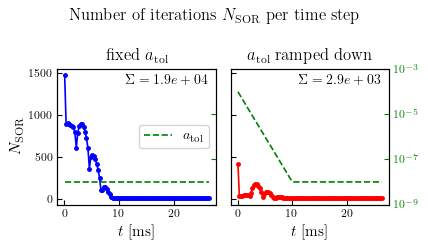

In [264]:
%autoreload 1
from visualization import plot_station_analysis

from plotting import set_size
plt.style.use('tex.mplstyle')
figsize = set_size(fraction=.7, aspect_r=0.4)

fig, axs = plt.subplots(1,2,sharex=True,sharey=True, figsize=figsize)

colors = ['blue', 'red']
labels = ['fixed $a_\mathrm{tol}$', '$a_\mathrm{tol}$ ramped down']

for i in range(2):
    
    L0, L2, NNSOR, T = Results[i]
    ydat = np.sum(NNSOR, axis=1) / Nt
    ax = axs[i]
    l2, = axs[i].plot(T * 1e3, ydat,'o-', color=colors[i])
    ax2 = axs[i].twinx()
    amax = 1e-8 if i==0 else 1e-4
    l, = ax2.plot(T * 1e3, get_atol(T, amin, amax, tmax),ls='--', color='green', label='$a_\mathrm{tol}$')
    ax2.tick_params(axis='y', colors=l.get_color()) 
    ax2.set_ylim(1e-9, 1e-3)
    ax2.set_yscale('log')
    if i==0:
        ax2.yaxis.set_ticklabels([])
        ax2.legend(loc='center right')
    ax.text(0.95, 0.95, '$\Sigma = {:.2g}$'.format(ydat.sum()), transform=ax.transAxes, horizontalalignment='right', verticalalignment='top')
    ax.set_xlabel('$t$ [ms]')
    ax.set_title(labels[i])
#ax2.set_ylabel('$a_\mathrm{tol}$')
plt.tight_layout()
fig.suptitle('Number of iterations $N_\mathrm{SOR}$ per time step')
axs[0].set_ylabel('$N_\mathrm{SOR}$')

#axs[0].yaxis.label.set_color(l2.get_color())

plt.tight_layout()

In [265]:
fig.savefig('figures/perfo_atol_explained.svg')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
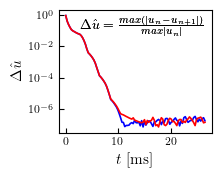

In [271]:
%autoreload 1
from visualization import plot_station_analysis
figsize = set_size(fraction=.37, aspect_r=0.3)
fig, ax = plt.subplots(figsize=figsize)

for i in range(2):
    L0, L2, NNSOR, T = Results[i]
    ax.plot(T * 1e3, L0[0], color=colors[i], label=labels[i])
    ax.set_yscale('log')
    #ax.plot(T * 1e3, get_atol(T, amin, amax, tmax), label='$a_\mathrm{tol}$')
    #plot_station_analysis(L0, L2, Nt, Nt0, N_loop, dt, dt_measure, fluid=True, axs=axs)
    s = r'$\Delta \hat{u} = \frac{ max ( |u_n -  u_{n+1}| ) }{ max |u_n| }$'
    ax.set_ylabel(r'$\Delta \hat{u}$')
    ax.text(0.95, 0.95, s, verticalalignment='top', horizontalalignment='right', transform=ax.transAxes)
#ax.legend(loc='center right', handlelength=0.5)
ax.set_xlabel('$t$ [ms]')
#.legend(loc='center right', handlelength=0.5, ncol=2, columnspacing=0.4)
plt.tight_layout()


In [273]:
fig.savefig('figures/perfo_atol_relative_change.svg')

In [214]:
ydat[0], ydat[1]

(1472.75, 889.875)

In [215]:
ydat.max(), ydat.max() / ydat.sum(), ydat.sum()

(1472.75, 0.0768012306970256, 19176.125)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
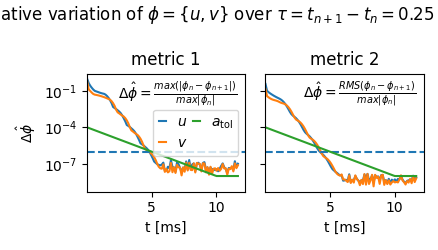

In [149]:
%autoreload 1
from visualization import plot_station_analysis

from plotting import set_size
#plt.style.use('tex.mplstyle')
figsize = set_size(fraction=.7, aspect_r=0.4)
fig, axs = plt.subplots(1,2,sharex=True, sharey=True, figsize=figsize)
plot_station_analysis(L0, L2, Nt, Nt0, N_loop, dt, dt_measure, fluid=True, axs=axs)

# display variation of atol:
T = np.arange(N_loop) * dt * Nt + dt * Nt0
for ax in axs:
    ax.plot(T * 1e3, get_atol(T, amin, amax, tmax), label='$a_\mathrm{tol}$')
axs[0].legend(loc='center right', handlelength=0.5, ncol=2, columnspacing=0.4)
plt.tight_layout()

if False:
    fig.savefig('figures/fluif_flow_station.svg')
    plt.style.use('default')